# Predictions using XGBoost on Tabular Data

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from src.data.prepare_data import format_tabular
from src.models.model import create_tabular_submission
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, plot_roc_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import RandomizedSearchCV
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from random import sample

In [3]:
SEED = 2718

These are the csv files containing patient data and file names.

In [4]:
train_internal = pd.read_csv('../data/internal/train.csv')
train_external = pd.read_csv('../data/external/train.csv')
test_raw = pd.read_csv('../data/internal/test.csv')

In [5]:
train_internal.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [6]:
test_raw.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


A formatting function has been created in a Python file for ease of use here.

In [7]:
X_train, X_test, y_train = format_tabular(train_internal, test_raw, count=False)

In [8]:
X_train.isna().sum()

sex                0
age_approx         0
width              0
height             0
NA                 0
head/neck          0
lower extremity    0
oral/genital       0
palms/soles        0
torso              0
upper extremity    0
dtype: int64

As can be seen below dummy columns have been created for the anatomical site of the lesion.

In [9]:
X_train.head()

,sex,age_approx,width,height,NA,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,1.0,45.0,6000,4000,0,1,0,0,0,0,0
1,0.0,45.0,6000,4000,0,0,0,0,0,0,1
2,0.0,50.0,1872,1053,0,0,1,0,0,0,0
3,0.0,45.0,1872,1053,0,1,0,0,0,0,0
4,0.0,55.0,6000,4000,0,0,0,0,0,0,1


Let's check the test dataframe matches the format of the training dataframe.

In [10]:
X_test.head()

,sex,age_approx,width,height,NA,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity
0,1.0,70.0,6000,4000,1,0,0,0,0,0,0
1,1.0,40.0,6000,4000,0,0,1,0,0,0,0
2,0.0,55.0,6000,4000,0,0,0,0,0,1,0
3,0.0,50.0,6000,4000,0,0,0,0,0,1,0
4,0.0,45.0,1920,1080,0,0,1,0,0,0,0


First we train using internal data. We will try random-over sampling of the minority class (malignant) and synthetic minority over-sampling (SMOTE). We will perform a randomized grid search over a selection of paramters for the sampling strategy and classifier. ROC-AUC score is the metric to assess performance and we will use triple-stratified leak-free 5-fold cross validation to assess performance.

In [11]:
model_randoversamp = Pipeline([
    ('sampler', RandomOverSampler(random_state=SEED)),
    ('classification', XGBClassifier(verbosity=1, random_state=SEED))
])

In [12]:
params_randoversamp = {
    'sampler__sampling_strategy': [0.1, 0.3, 0.5],
    'classification__eta': [0.0001, 0.001, 0.01, 0.1, 1],
    'classification__gamma': [0, 1, 2, 3, 4, 5],
    'classification__max_depth': [x for x in range(1, 11)],
    'classification__n_estimators': [50, 100, 150, 200]
}

In [13]:
cv_iterator_int = []
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (idxT,idxV) in enumerate(skf.split(np.arange(15))):
    cv_iterator_int.append((train_internal.tfrecord.isin(idxT), 
                        train_internal.tfrecord.isin(idxV)))

In [14]:
grid_randoversamp = RandomizedSearchCV(estimator=model_randoversamp, 
                          param_distributions=params_randoversamp, 
                          n_iter=100, 
                          scoring='roc_auc', 
                          cv=cv_iterator_int, 
                          verbose=1, 
                          n_jobs=-1)

In [15]:
grid_randoversamp.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.2min finished


RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classif

As we can see below the score is impressive for a purely tabular model. We save the submission to be sent to Kaggle.

In [16]:
grid_randoversamp.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718, sampling_strategy=0.3)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=2, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=0, num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [17]:
grid_randoversamp.best_score_

0.8300664870811059

In [18]:
create_tabular_submission(grid_randoversamp, X_test, '../data/internal/sample_submission.csv', 'xgboost_internal_randomoversampling')

In [19]:
filename = "../models/xgboost_internal_randomoversampling.pkl"
with open(filename, 'wb') as file:
    pickle.dump(grid_randoversamp, file)

This submission achieved a score of 0.7981 on the Kaggle public leaderboard. Now we will try using the SMOTE sampler with the same parameters for classification using XGBoost.

In [20]:
model_smote = Pipeline([
    ('sampler', SMOTE(random_state=SEED, n_jobs=-1)),
    ('classification', XGBClassifier(verbosity=1, random_state=SEED))
])

In [21]:
params_smote = {
    'sampler__k_neighbors': [1, 3, 5, 7],
    'classification__eta': [0.0001, 0.001, 0.01, 0.1, 1],
    'classification__gamma': [0, 1, 2, 3, 4, 5],
    'classification__max_depth': [x for x in range(1, 11)],
    'classification__n_estimators': [50, 100, 150, 200]
}

In [22]:
grid_smote = RandomizedSearchCV(estimator=model_smote, 
                                param_distributions=params_smote, 
                                n_iter=100, 
                                scoring='roc_auc', 
                                cv=cv_iterator_int, 
                                verbose=1, 
                                n_jobs=-1)

In [23]:
grid_smote.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.0min finished


RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                                            subsample=None,
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
              

In [24]:
grid_smote.best_estimator_

Pipeline(steps=[('sampler', SMOTE(k_neighbors=1, n_jobs=-1, random_state=2718)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=2, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [25]:
grid_smote.best_score_

0.8218245363414788

In [26]:
create_tabular_submission(grid_smote, X_test, '../data/internal/sample_submission.csv', 'xgboost_internal_smote')

This achieved a score of 0.7664 on the public leaderboard.

Now let's try adding external data with random over-sampling, as that performed better on the CV data than the SMOTE sampling.

In [27]:
X_ext_train, y_ext_train = format_tabular(train_external)

The 2019 data provided three separate torso areas for the lesions. The 2020 data only contained a general torso category so the three must be combined to one to match the internal training data. We will then concatenate the dataframes and train. We need to create a new cross-validation iterator which puts the external data only in training sets. It must not be used for validation and it may not be representative of the testing data.

In [28]:
X_ext_train['torso'] = X_ext_train['anterior torso'] + X_ext_train['posterior torso'] + X_ext_train['lateral torso']

In [29]:
X_ext_train.drop(['anterior torso', 'posterior torso', 'lateral torso'], axis=1, inplace=True)

In [30]:
X_train_all = pd.concat([X_train, X_ext_train], axis=0, ignore_index=True)
y_train_all = pd.concat([y_train, y_ext_train], axis=0, ignore_index=True)

In [31]:
tf_int = train_internal['tfrecord']
tf_ext = train_external['tfrecord']
tf_ext += 20
tf = pd.concat([tf_int, tf_ext], axis=0, ignore_index=True)

In [32]:
cv_iterator_ext = []
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)
for i, (idxT,idxV) in enumerate(skf.split(np.arange(15))):
    cv_iterator_ext.append((tf.isin(idxT) | (tf >= 20), 
                        tf.isin(idxV)))

In [33]:
grid_randoversamp_ext = RandomizedSearchCV(estimator=model_randoversamp, 
                                       param_distributions=params_randoversamp, 
                                       n_iter=100, 
                                       scoring='roc_auc', 
                                       cv=cv_iterator_ext, 
                                       verbose=1, 
                                       n_jobs=-1)

In [34]:
grid_randoversamp_ext.fit(X=X_train_all, y=y_train_all)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.6min finished


RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
58452    True
58453    True
58454    True
58455    True
58456    True
Name: tfrecord, Length: 58457, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
58452    False
58453    False
58454    False
58455    False
58456    False
Name: tfrecord, Length: 58457, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
58452     True
58453     True
58454     True
58455     True
58456     True
Name: tfrecord, Leng...
                                                            tree_method=None,
                                                            validate_parameters=None,
                                                            verbosity=1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classif

In [35]:
grid_randoversamp_ext.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718, sampling_strategy=0.3)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.1, gamma=5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.100000001, max_delta_step=0,
                               max_depth=4, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=1))])

In [36]:
grid_randoversamp_ext.best_score_

0.8278927890426413

This score is almost exactly as using the internal data but we will still try submitting. This model scored 0.7959 on the public leaderboard so a small amount worse than just using the internal data. As both internal and internal+external achieved almost identical CV scores we will stick to jsut using the internal data as it is much quicker.

In [37]:
create_tabular_submission(grid_randoversamp_ext, X_test, '../data/internal/sample_submission.csv', 'xgboost_external_randover')

Finally, can we find any parameters for the classification which perform better by searching for longer using probability distributions for the parameters rather than lists?

In [38]:
params_randoversamp = {
    'sampler__sampling_strategy': stats.uniform(0.1, 0.5),
    'classification__eta': stats.gamma(a=2, scale=0.05),
    'classification__gamma': stats.gamma(a=2, scale=1),
    'classification__max_depth': stats.randint(low=1, high=3),
    'classification__n_estimators': stats.randint(low=100, high=300),
}

In [39]:
grid_randoversamp = RandomizedSearchCV(estimator=model_randoversamp, 
                                       param_distributions=params_randoversamp, 
                                       n_iter=200, scoring='roc_auc', 
                                       cv=cv_iterator_int, 
                                       verbose=1, 
                                       random_state=SEED, 
                                       n_jobs=-1)

In [40]:
grid_randoversamp.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.4min finished


RandomizedSearchCV(cv=[(0        True
1        True
2        True
3        True
4        True
         ... 
33121    True
33122    True
33123    True
33124    True
33125    True
Name: tfrecord, Length: 33126, dtype: bool,
                        0        False
1        False
2        False
3        False
4        False
         ...  
33121    False
33122    False
33123    False
33124    False
33125    False
Name: tfrecord, Length: 33126, dtype: bool),
                       (0         True
1         True
2        False
3         True
4         True
         ...  
33121     True
33122     True
33123     True
33124     True
33125     True
Name: tfrecord, Leng...
                                        'classification__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8cfd7e8a30>,
                                        'classification__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8cfd7c70a0>,
                                        'classificati

In [41]:
grid_randoversamp.best_estimator_

Pipeline(steps=[('sampler',
                 RandomOverSampler(random_state=2718,
                                   sampling_strategy=0.41151534199277284)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eta=0.23951759613943807,
                               gamma=2.4114543816183067, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.239517599, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=192,
                               n_jobs=0, num_parallel_tree=1, random_state=2718,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                        

In [42]:
grid_randoversamp.best_score_

0.8312660030607418

This is slightly better than before. Let's see how it does on the test set and save the model.

In [45]:
create_tabular_submission(grid_randoversamp, X_test, '../data/internal/sample_submission.csv', 'xgboost_internal_randover_dist')

This one scored 0.8166 so a good improvement by searching using more varied parameters.

In [46]:
filename = "../models/xgboost_internal_randomoversamplingdist.pkl"

In [47]:
with open(filename, 'wb') as file:
    pickle.dump(grid_randoversamp, file)

In [48]:
with open(filename, 'rb') as file:
    final_model = pickle.load(file)

Finally we will make some plots to examine how the XGBoost classifier is making decisions

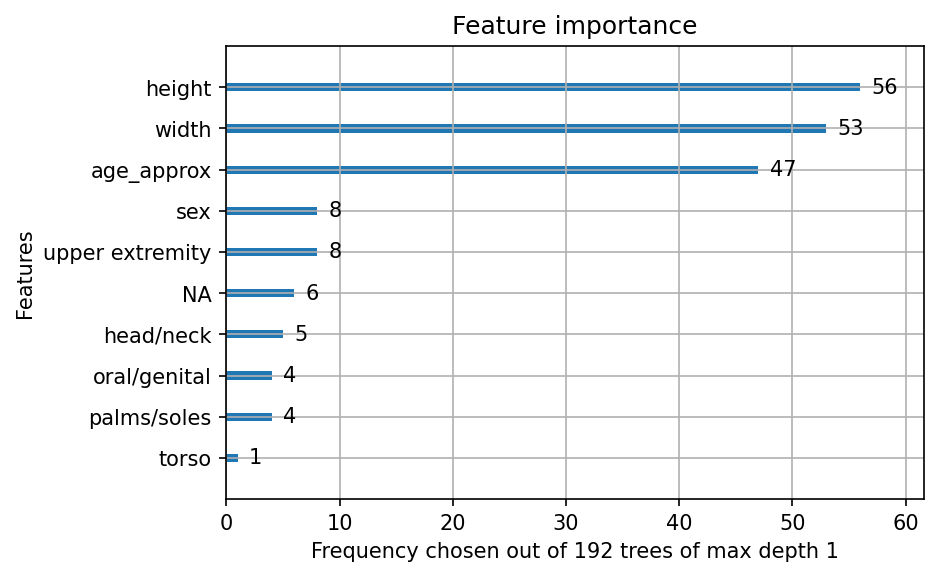

In [49]:
fig, ax = plt.subplots(dpi=150)
plot_importance(final_model.best_estimator_.named_steps["classification"], 
                ax=ax, 
                xlabel=f"Frequency chosen out of {final_model.best_params_['classification__n_estimators']} trees of max depth {final_model.best_params_['classification__max_depth']}")
fig.savefig('../images/feature_importance.png', bbox_inches = "tight")

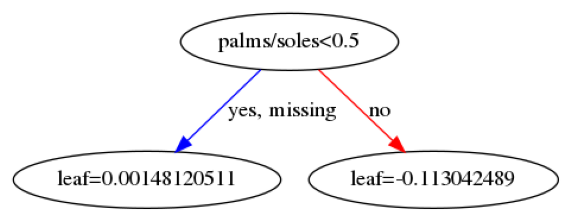

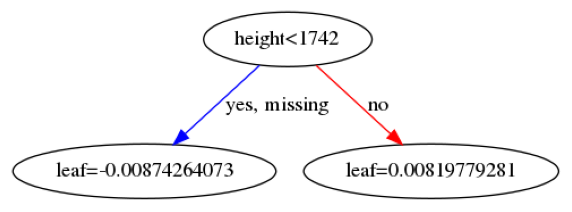

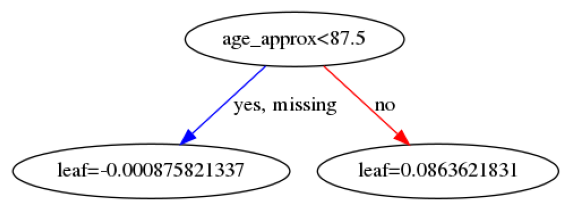

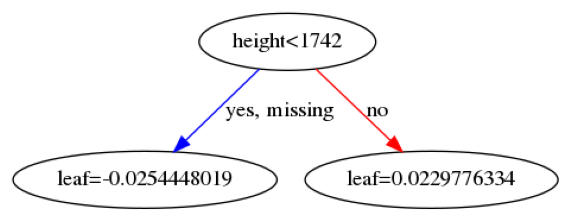

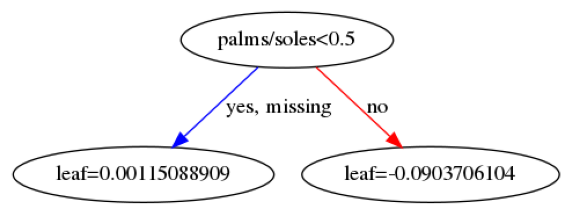

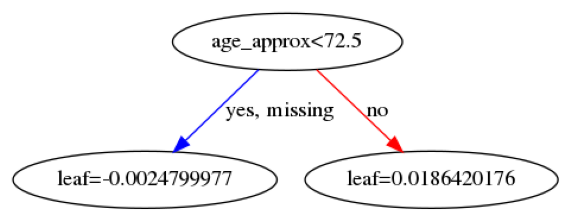

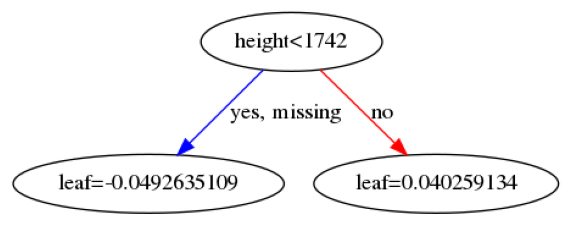

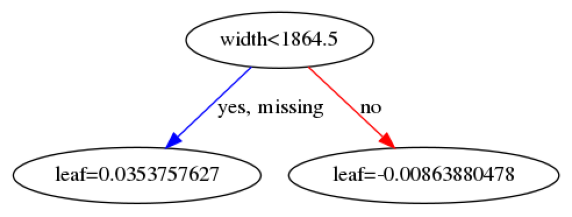

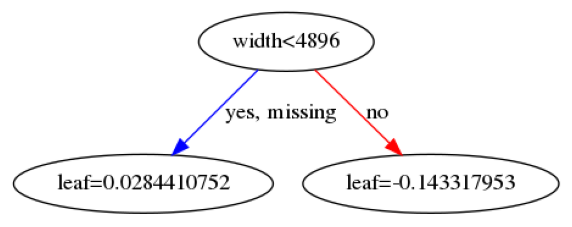

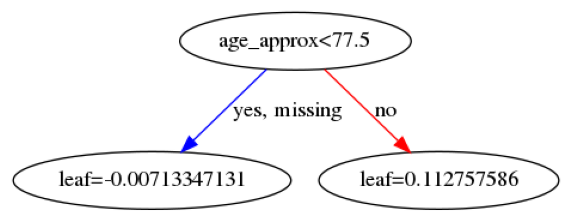

In [50]:
for i in sample(set(np.arange(final_model.best_params_['classification__n_estimators'])), 10):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_tree(final_model.best_estimator_.named_steps["classification"], num_trees=i, ax=ax)
    fig.savefig(f'../images/tree_{i}.png')

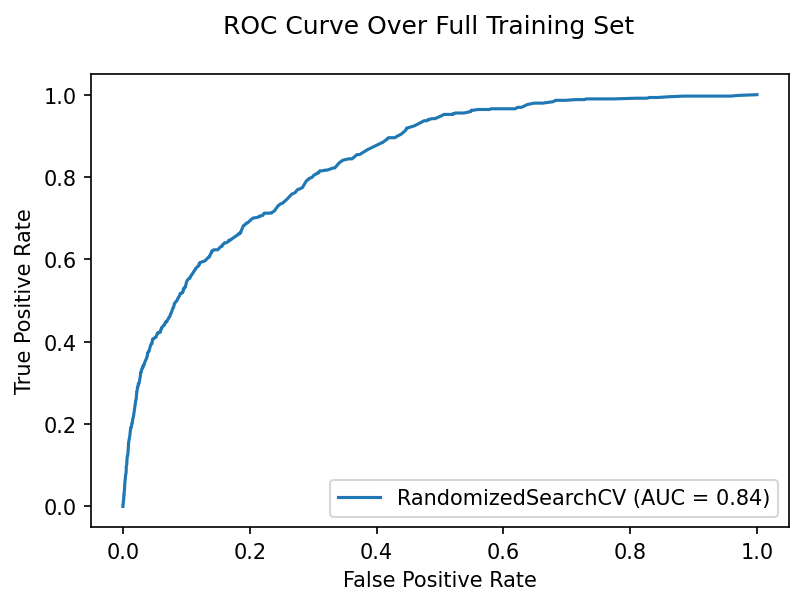

In [51]:
fig, ax = plt.subplots(dpi=150)
f = plot_roc_curve(final_model, X_train, y_train, ax=ax)
f.figure_.suptitle('ROC Curve Over Full Training Set')
f.figure_.savefig('../images/roc_curve.png')